# Импортируем необходимые модули и зададим функцию моделирования изображения

In [214]:
from skimage import io
import numpy as np
import random as rand
from copy import deepcopy
def autoreg_img(name = 'autoreg_model.png', h = 256, w = 256, depend_el = [(0, -1), (-1, 0), (-1, -1)], \
               coef_ = np.array([0.1, 0.1, 0.1])):
    data = np.zeros((h, w), dtype=float)
    data_1 = np.zeros((h, w), dtype=int)
    #инициализируем генератор случайных чисел
    #np.random.seed(100)
    #noise_arr = np.random.random(h*w)
    #зададим шум на всей решетке
    cnt = 0
    for i in range(0, h):
        for j in range(0, w):
            data[i, j]+=np.random.normal(loc = 0., scale = 0.05)
            cnt+=1
    #зададим уравнение линейной регрессии для всех элементов массива, без нулевой строки и нулевого столбца
    for i in range(1, h):
        for j in range(1, w):
            for k in range(len(depend_el)):
                data[i, j] += coef_[k]*data[i+depend_el[k][0], j+depend_el[k][1]]
    #return data
    #массив задан, нормализуем, сдвинем все элементы на минимум массива вправо по оси x \
    #сейчас уже 255 нормируем на максимум массива
    dat_aux = np.array([np.min(data) for i in range(h*w)]).reshape(h, w)
    data-=dat_aux
            
    norm_coef = 255./float(data.max())
    data*=norm_coef
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data_1[i][j] = int(data[i][j])
    #return data.max()
    #Моделируем и сохраняем изображение
    #img = Image.fromarray(data, mode = 'P')
    io.imsave(name, data_1)
    io.imshow(data_1, cmap='gray')
    return 'If method Show is not working, check image in the system directory'\
    #, (data, norm_coef)

# Изображение с параметрами по умолчанию

'If method Show is not working, check image in the system directory'

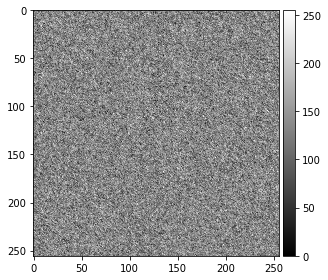

In [212]:
autoreg_img()

# Моделирование изображение с заданием других параметров

C:\Users\Cherry\Anaconda2\lib\site-packages\skimage\io\_io.py:132: UserWarning: C:\Users\Cherry\modeling_images\fourth.png is a low contrast image
  warn('%s is a low contrast image' % fname)


'If method Show is not working, check image in the system directory'

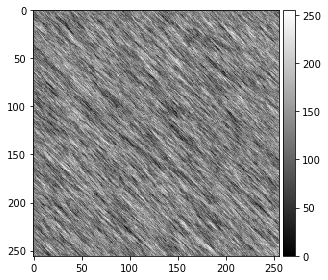

In [3]:
autoreg_img(name = 'C:\\Users\\Cherry\\modeling_images\\fourth.png',depend_el = [(0, -1), (-1, 0), (-1, -1)], \
               coef_ = np.array([0.1, 0.1, 0.7]))

# Зависимость от двух элементов

Wall time: 56.1 s


'If method Show is not working, check image in the system directory'

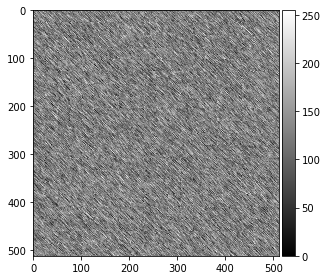

In [189]:
%%time
autoreg_img(h = 512, w = 512, depend_el = [(-1, -1)], \
               coef_ = np.array([0.8]))

# Считаем выборочную автокорреляцию и составляем соответсвующую матрицу для маски [(1, 0), (0, 1), (1, 1)]

## Функция подсчета автокорреляций

In [215]:
def autocov(img, x_delta = 0, y_delta = 1):
    # avg = img.reshape(img.shape[0]*img.shape[1], 1).mean()
    c, c_0 = 0., 0.
    #img_ = deepcopy(img)
    #for i in range(img.shape[0]):
    #    for j in range(img.shape[1]):
    #        img[i, j]-=img_.mean()
    if (x_delta == 0 and y_delta == 1):
        avg = img[1:, :-1].reshape((img.shape[0]-1)*(img.shape[1]-1), 1).mean()
        for i in range(1, img.shape[0]):
            for j in range(img.shape[1]-1):
                c += (img[i][j]-avg)*(img[i+x_delta][j+y_delta]-avg)
                c_0 += (img[i][j]-avg)**2
    elif (x_delta == 1 and y_delta == 0):
        avg = img[:-1, 1:].reshape((img.shape[0]-1)*(img.shape[1]-1), 1).mean()
        for i in range(img.shape[0]-1):
            for j in range(1, img.shape[1]):
                c += (img[i][j]-avg)*(img[i+x_delta][j+y_delta]-avg)
                c_0 += (img[i][j]-avg)**2
    else:
        avg = img[:-1, :-1].reshape((img.shape[0]-1)*(img.shape[1]-1), 1).mean()
        for i in range(img.shape[0]-1):
            for j in range(img.shape[1]-1):
                c += (img[i][j]-avg)*(img[i+x_delta][j+y_delta]-avg)
                c_0 += (img[i][j]-avg)**2
    return c/c_0

# Задаем и решаем уравнения Юла-Уокера

'If method Show is not working, check image in the system directory'

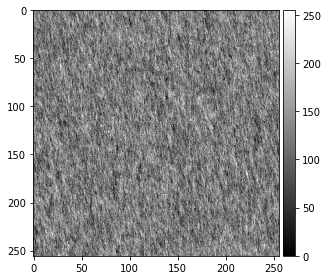

In [192]:
autoreg_img(depend_el = [(0, -1), (-1, 0), (-1, -1)], \
               coef_ = np.array([0.1, 0.6, 0.1]))

## Функция решения ур-ий Юла-Уокера

In [216]:
def yule_walker_sol(file_name = 'autoreg_model.png'):
    data_arr = io.imread(str(file_name)).astype(dtype = 'int32')
    # считаем автокорреляции
    r_1 = autocov(img = data_arr, x_delta = 0, y_delta = 1)
    r_2 = autocov(img = data_arr, x_delta = 1, y_delta = 0)
    r_3 = autocov(img = data_arr, x_delta = 1, y_delta = 1)
    # сост. соотв. матрицу и столбец
    P_ro = np.array([[1., r_1, r_2],
                 [r_1, 1., r_1],
                 [r_2, r_1, 1.]])
    ro = np.array([r_1, r_2, r_3]).reshape(3, 1)
    # подставляем в ур-ие Юла-Уокера и считаем коэфф. модели
    print 'Estimated params:[0, -1] - %f; [-1, 0] - %f; [-1, -1] - %f;' %\
    tuple([float(i) for i in np.linalg.solve(P_ro, ro)])
    return (tuple([float(i) for i in np.linalg.solve(P_ro, ro)]))

'If method Show is not working, check image in the system directory'

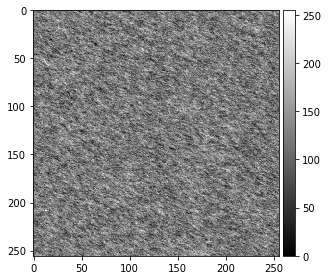

In [78]:
autoreg_img(name = 'C:\\Users\\Cherry\\estimation_images\\second_orig.png',depend_el = [(0, -1), (-1, 0), (-1, -1)], \
               coef_ = np.array([0.4, 0.1, 0.2]))

In [84]:
coef_n = yule_walker_sol('C:\\Users\\Cherry\\estimation_images\\second_orig.png')
print coef_n

Estimated params:[0, -1] - 0.436211; [-1, 0] - -0.095509; [-1, -1] - 0.280491;
(0.436210766820131, -0.09550880865239027, 0.28049062136490494)


C:\Users\Cherry\Anaconda2\lib\site-packages\skimage\io\_io.py:132: UserWarning: C:\Users\Cherry\estimation_images\second_est.png is a low contrast image
  warn('%s is a low contrast image' % fname)


'If method Show is not working, check image in the system directory'

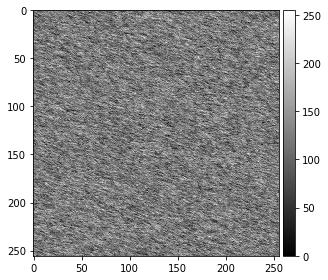

In [7]:
autoreg_img(name = 'C:\\Users\\Cherry\\estimation_images\\second_est.png',depend_el = [(0, -1), (-1, 0), (-1, -1)], \
               coef_ = np.array(coef_n))

# Сегментация изображений

## Слепим изображение из 2 разных моделей. Одна половина - авторегрессия с одной маской, вторая - с другой

# без шумовой верхней границы

In [223]:
def autoreg_img_half(h = 64, w = 128, h_1 = 64, depend_el = [(0, -1), (-1, 0), (-1, -1)], \
               coef_ = np.array([0.2, 0.2, 0.2]), coef_1 = np.array([0.1, 0.1, 0.7])):
    data = np.zeros((h, w), dtype=float)
    #data_1 = np.zeros((h, w), dtype=int)
    #инициализируем генератор случайных чисел
    #np.random.seed(100)
    #noise_arr = np.random.random(h*w)
    #зададим шум на всей решетке
    for i in range(0, h):
        for j in range(0, w):
            data[i, j]+=(rand.normalvariate(0., 0.05))
    #зададим уравнение линейной регрессии для всех элементов массива, без нулевой строки и нулевого столбца
    for i in range(1, h):
        for j in range(1, w):
            for k in range(len(depend_el)):
                data[i, j] += coef_[k]*data[i+depend_el[k][0], j+depend_el[k][1]]
    dat_d = np.zeros((h_1+1, 128), dtype=float)
    for i in range(0, dat_d.shape[0]):
        for j in range(0, dat_d.shape[1]):
            dat_d[i, j]+=(rand.normalvariate(0., 0.05))
    dat_d[0] = data[-1]
    for i in range(0, dat_d.shape[0]):
        for j in range(0, dat_d.shape[1]):
            for k in range(len(depend_el)):
                dat_d[i, j] += coef_1[k]*dat_d[i+depend_el[k][0], j+depend_el[k][1]]
    dat_f = np.vstack((data, dat_d[1:]))
    data_1 = np.zeros((dat_f.shape[0], dat_f.shape[1]), dtype=int)
    dat_aux = np.array([np.min(dat_f) for i in range(128*128)]).reshape(128, 128)
    dat_f-=dat_aux
    norm_coef = 255./float(dat_f.max())
    dat_f*=norm_coef
    for i in range(data_1.shape[0]):
        for j in range(data_1.shape[1]):
            data_1[i][j] = int(dat_f[i][j])
    #data_1
    io.imshow(data_1, cmap='gray')
    io.imsave('half_im.png', data_1, cmap = 'gray')
    return data_1

array([[123,  91, 153, ..., 126, 158, 121],
       [164, 156, 115, ..., 138, 134, 131],
       [162, 183, 126, ..., 137, 161, 132],
       ...,
       [159, 145, 130, ..., 147,  80,  74],
       [ 64, 131, 165, ..., 146, 128,  55],
       [101,  52, 164, ..., 146, 105, 153]])

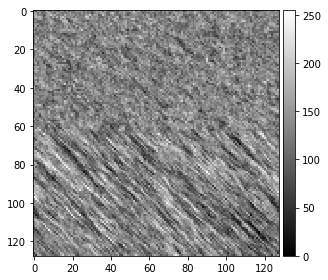

In [224]:
autoreg_img_half()

In [ ]:
data = np.zeros((h_1+1, 128), dtype=float)
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        data[i, j]+=(rand.normalvariate(0., 0.05))
dat_d = autoreg_img_half(coef_ = np.array([0.2, 0.2, 0.2]))
data[0] = dat_d[-1]
depend_el = [(0, -1), (-1, 0), (-1, -1)]
coef_ = np.array([0.1, 0.1, 0.7])
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        for k in range(len(depend_el)):
            data[i, j] += coef_[k]*data[i+depend_el[k][0], j+depend_el[k][1]]
dat_f = np.vstack((dat_d, data[1:]))

data_1 = np.zeros((dat_f.shape[0], dat_f.shape[1]), dtype=int)

dat_aux = np.array([np.min(dat_f) for i in range(128*128)]).reshape(128, 128)
dat_f-=dat_aux
norm_coef = 255./float(dat_f.max())
dat_f*=norm_coef

for i in range(data_1.shape[0]):
    for j in range(data_1.shape[1]):
        data_1[i][j] = int(dat_f[i][j])
#data_1
io.imshow(data_1, cmap='gray')
io.imsave('half_im.png', data_1, cmap = 'gray')

## Коэффициенты верхнего региона: [0.1, 0.1, 0.1], нижнего региона: [0.3, 0.15, 0.35]

## Функция, разворачивающая кластеризацию на сыром изображении. Возвращает центры кластеров и визуализируем все наборы коэффициентов

In [219]:
def yule_walker_sol_arr(data_arr):
    #data_arr = io.imread(str(file_name))
    # считаем автокорреляции
    r_1 = autocov(img = data_arr, x_delta = 0, y_delta = 1)
    r_2 = autocov(img = data_arr, x_delta = 1, y_delta = 0)
    r_3 = autocov(img = data_arr, x_delta = 1, y_delta = 1)
    # сост. соотв. матрицу и столбец
    P_ro = np.array([[1., r_1, r_2],
                 [r_1, 1., r_1],
                 [r_2, r_1, 1.],])
    ro = np.array([r_1, r_2, r_3]).reshape(3, 1)
    # подставляем в ур-ие Юла-Уокера и считаем коэфф. модели
    return (tuple([round(float(i), 4) for i in np.linalg.solve(P_ro, ro)]))

In [217]:
from sklearn import cluster
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

def clust_coefs(data_arr):
    a = []
    for i in range(0, int(data_1.shape[0]*0.75)+1, 8):
        for j in range(0, int(data_1.shape[1]*0.75)+1, 8):
            a.append(yule_walker_sol_arr(data_1[i:i+32, j:j+32]))
    a = np.array(a).reshape(len(a), 3)
    km_alg = cluster.KMeans(n_clusters=2).fit(a)
    
    tr_ind = []
    f_ind = []
    for i in range(len(km_alg.labels_)):
        if km_alg.labels_[i] == 1:
            tr_ind.append(i)
        else:
            f_ind.append(i)
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')

    # 1st cluster
    xs = a[[tr_ind]][:,0]
    ys = a[[tr_ind]][:,1]
    zs = a[[tr_ind]][:,2]
    ax.scatter(xs, ys, zs, c='r', marker='o')

    # 2nd cluster
    xs = a[[f_ind]][:,0]
    ys = a[[f_ind]][:,1]
    zs = a[[f_ind]][:,2]
    ax.scatter(xs, ys, zs, c='b', marker='^')

    ax.set_xlabel('[0, -1]')
    ax.set_ylabel('[-1, 0]')
    ax.set_zlabel('[-1, -1]')
    return km_alg.cluster_centers_

array([[0.08357363, 0.07781648, 0.68406044],
       [0.16960385, 0.13842564, 0.23648846]])

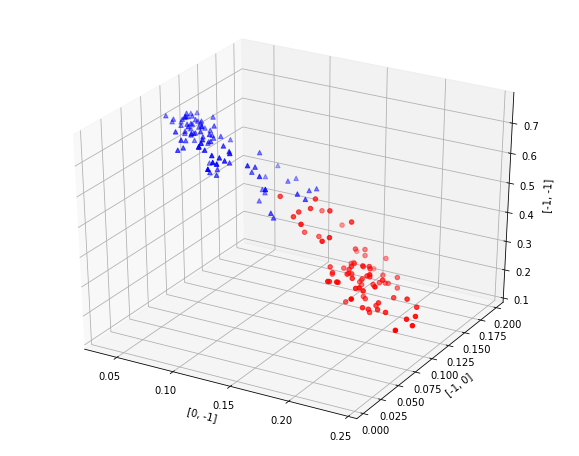

In [220]:
clust_coefs(data_1)

## Значения получились адекватные, но видны выбросы, которые вообще говоря образуют отдельный кластер. Работать все равно будем с 2 кластерами, но рассмотрим и положения центров трех.

In [213]:
km_alg_1 = cluster.KMeans(n_clusters=3).fit(a)
km_alg_1.cluster_centers_

array([[0.28196944, 0.03858194, 0.42186944],
       [0.11107681, 0.09942464, 0.10160725],
       [0.22588214, 0.0895    , 0.27311786]])

In [207]:
km_alg_1.cluster_centers_[0][1]

0.09942463768115942

## Непосредственно сегментация. Считаем $h_1$ и $h_2$: $h_k = (w_k)^2/(\sigma_k)^2 + ln(\sigma_k)^2$ Какая из величин меньше, к той модели и принадлежит пиксель. Дисперсия шума у нас в моделях одинаковая, тогда просто сравниваем квадрат ошибки, т.е. $(w_k)^2 при: k = 1, 2$

In [208]:
coefs_1 = km_alg.cluster_centers_
coefs_1

array([[0.27501685, 0.04911573, 0.40099663],
       [0.12267875, 0.09716125, 0.11680125]])

In [209]:
data_1[64:,:].shape

(64L, 128L)

In [210]:
np.vstack((np.array(yule_walker_sol_arr(data_1[:64,:])).reshape(1,3), \
np.array(yule_walker_sol_arr(data_1[64:,:])).reshape(1,3)))

array([[0.1044, 0.1044, 0.0929],
       [0.292 , 0.0267, 0.4326]])

Тут номинально первая область - верхняя, т.е. с коэффициентами: [0.1, 0.1, 0.1]. Ее в иделале мы должны полностью окрасить в темный цвет (интенсивность - 1).

## Первая функция возвращает словарь с соответствующим значением интенсивности в каждом пикселе, вторая - подводит результаты и строит изображение после сегментации.

In [228]:
def segm_dict(coefs, data = data_1):
    depend_el = [(0, -1), (-1, 0), (-1, -1)]
    # Вычтем из нашей матрицы среднее:
    data_1_ = deepcopy(data)
    m = np.mean(data)
    for i in range(data_1_.shape[0]):
        for j in range(data_1_.shape[1]):
            data_1_[i, j]-=m
    dict_segm = {}
    for i in range(1, data.shape[0]):
        for j in range(1, data.shape[1]):
            w_1 = coefs[0][2]*data_1_[i-1, j-1]+coefs[0][1]*data_1_[i-1, j]+ coefs[0][0]*data_1_[i, j-1] - data_1_[i, j]
            w_2 = coefs[1][2]*data_1_[i-1, j-1]+coefs[1][1]*data_1_[i-1, j]+ coefs[1][0]*data_1_[i, j-1] - data_1_[i, j]
            if w_1**2 < w_2**2:
                dict_segm.update({(i, j): 1})
            else:
                dict_segm.update({(i, j): 255})
    return dict_segm

def segm_result(dict_segm, bound = 4, h = 124, w = 124, h_ = 64, w_ = 64, type_ = 'half',\
                name = 'C:\\Users\\Cherry\\segmentation_images\\first_sq_single_segm.png'):
    right_1st, wrong_1st, right_2nd, wrong_2nd = 0, 0, 0, 0
    if type_ == 'half':
        for i in range(len(dict_segm.keys())):
            if dict_segm.keys()[i][0] < h_-bound:
                if dict_segm[dict_segm.keys()[i]] == 1:
                    right_1st+=1
                else: wrong_1st+=1
            else:
                if dict_segm[dict_segm.keys()[i]] == 255:
                    right_2nd+=1
                else: wrong_2nd+=1
        print 'Верхняя область: верно сегментированных пикселей - %i, неверно - %i, доля - %f' % (right_1st, wrong_1st,\
                                                                                    float(right_1st)/(right_1st+wrong_1st))
        print 'Нижняя область: верно сегментированных пикселей - %i, неверно - %i, доля - %f' % (right_2nd, wrong_2nd,\
                                                                                                float(right_2nd)/(right_2nd+wrong_2nd))
        #return {'right_1st':right_1st, 'wrong_1st':wrong_1st, 'right_2nd':right_2nd, 'wrong_2nd':wrong_2nd}
    
    elif type_ == 'square':
        for i in range(len(dict_segm.keys())):
            if (dict_segm.keys()[i][0] < ((128-h_)/2)+h_-1-bound) and (dict_segm.keys()[i][0]>=((128-h_)/2)-2-bound) and \
            (dict_segm.keys()[i][1] < ((128-w_)/2)+w_-1-bound) and (dict_segm.keys()[i][1] >= ((128-w_)/2)-2-bound):
                if dict_segm[dict_segm.keys()[i]] == 255:
                    right_1st+=1
                else: wrong_1st+=1
            else:
                if dict_segm[dict_segm.keys()[i]] == 1:
                    right_2nd+=1
                else: wrong_2nd+=1
        print 'Фоновая область: верно сегментированных пикселей - %i, неверно - %i, доля - %f' % (right_1st, wrong_1st,\
                                                                                                 float(right_1st)/(right_1st+wrong_1st))
        print 'Внутренняя область: верно сегментированных пикселей - %i, неверно - %i, доля - %f' % (right_2nd, wrong_2nd,\
                                                                                                    float(right_2nd)/(right_2nd+wrong_2nd))
        #return {'right_1st':right_1st, 'wrong_1st':wrong_1st, 'right_2nd':right_2nd, 'wrong_2nd':wrong_2nd}
    elif type_ == 'triangle':
        for i in range(len(dict_segm.keys())):
            if (dict_segm.keys()[i][0] < ((128-h_)/2)+h_-1-bound) and (dict_segm.keys()[i][0]>=((128-h_)/2)-2-bound) and \
            (dict_segm.keys()[i][1] < ((128-w_)/2)+w_-1-bound) and (dict_segm.keys()[i][1] >= ((128-w_)/2)-2-bound) and \
            (dict_segm.keys()[i][1] <= dict_segm.keys()[i][0]):
                if dict_segm[dict_segm.keys()[i]] == 255:
                    right_1st+=1
                else: wrong_1st+=1
            else:
                if dict_segm[dict_segm.keys()[i]] == 1:
                    right_2nd+=1
                else: wrong_2nd+=1
        print 'Фоновая область: верно сегментированных пикселей - %i, неверно - %i, доля - %f' % (right_1st, wrong_1st,\
                                                                                                 float(right_1st)/(right_1st+wrong_1st))
        print 'Внутренняя область: верно сегментированных пикселей - %i, неверно - %i, доля - %f' % (right_2nd, wrong_2nd,\
                                                                                                    float(right_2nd)/(right_2nd+wrong_2nd))
    else:
        print 'Type_ value must be half, square or triangle'
    #make image
    dat_segm = np.zeros((h, w), dtype = int)
    for i in range(dat_segm.shape[0]):
        for j in range(dat_segm.shape[1]):
            dat_segm[i, j] = int(dict_segm[(i+bound, j+bound)])
    io.imshow(dat_segm, cmap='gray')
    #print dat_segm[0]

    io.imsave(name, dat_segm)
    #print 'Check image in half_im_segm.png'
    
    return {'right_1st':right_1st, 'wrong_1st':wrong_1st, 'right_2nd':right_2nd, 'wrong_2nd':wrong_2nd}

### При коэффициентах, полученных с помощью оценок участков и дальнейшей кластеризации

In [201]:
km_alg.cluster_centers_

array([[0.08703187, 0.07542747, 0.67787363],
       [0.16878462, 0.14727051, 0.25032564]])

Верхняя область: верно сегментированных пикселей - 4660, неверно - 2284, доля - 0.671083
Нижняя область: верно сегментированных пикселей - 6897, неверно - 1535, доля - 0.817955


{'right_1st': 4660, 'right_2nd': 6897, 'wrong_1st': 2284, 'wrong_2nd': 1535}

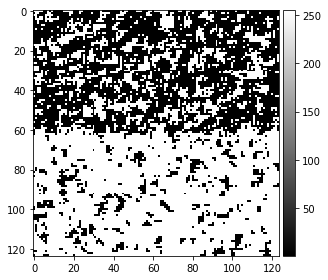

In [202]:
segm_result(name='C:\\Users\\Cherry\\segmentation_images\\last_half_clust.png',\
            h=124, w=124, dict_segm=segm_dict_sq_bound(bound = 4, data = data_1, coefs = np.array([km_alg.cluster_centers_[1],
                                                                                                  km_alg.cluster_centers_[0]])),\
            bound = 4)

### При оценках параметров каждой области в лоб

In [130]:
(np.array(yule_walker_sol_arr(data_1[:64,:])).reshape(1,3), np.array(yule_walker_sol_arr(data_1[64:,:])).reshape(1,3))

(array([[0.164 , 0.1691, 0.232 ]]), array([[0.073 , 0.0788, 0.7165]]))

Верхняя область: верно сегментированных пикселей - 5120, неверно - 2692, доля - 0.655402
Нижняя область: верно сегментированных пикселей - 6364, неверно - 1200, доля - 0.841354


C:\Users\Cherry\Anaconda2\lib\site-packages\skimage\io\_io.py:132: UserWarning: C:\Users\Cherry\segmentation_images\last_half_est.png is a low contrast image
  warn('%s is a low contrast image' % fname)


{'right_1st': 5120, 'right_2nd': 6364, 'wrong_1st': 2692, 'wrong_2nd': 1200}

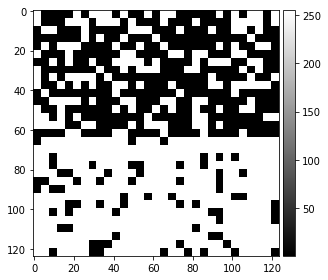

In [137]:
segm_result(name='C:\\Users\\Cherry\\segmentation_images\\last_half_est.png',\
            h=124, w=124, dict_segm=segm_dict_sq_bound(data = data_1, coefs = np.vstack((np.array(yule_walker_sol_arr(data_1[:64,:])).reshape(1,3), \
np.array(yule_walker_sol_arr(data_1[64:,:])).reshape(1,3)))), bound = 4)

### При истинных значениях коэффициентов

Верхняя область: верно сегментированных пикселей - 4463, неверно - 3538
Нижняя область: верно сегментированных пикселей - 4740, неверно - 3388
Check image in half_im_segm.png


{'right_1st': 4463, 'right_2nd': 4740, 'wrong_1st': 3538, 'wrong_2nd': 3388}

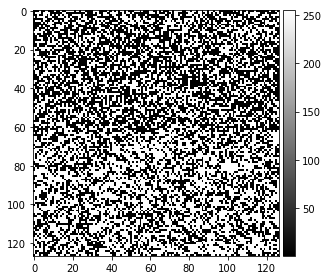

In [215]:
segm_result(dict_segm=segm_dict(data = data_1, coefs = np.array([[0.1, 0.1, 0.1],
                                                                 [0.3, 0.1, 0.35]])))

### Результаты не совсем те, которые мы хотели бы видеть. Попробуем считать ошибки не для каждого конкретного пикселя (т.е. рассматривать квадраты из 4 пикселей (2 на 2)), а для квадратов 2 на 2 (4 пикселей) (т.е. рассматривать будем квадраты из 9 пикселей (3 на 3)).

In [13]:
def err_sq(a, b):
    err = 0
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            err+=(a[i, j]-b[i,j])**2
    return err

def segm_dict_sq(coefs, data = data_1):
    depend_el = [(0, -1), (-1, 0), (-1, -1)]
    # Вычтем из нашей матрицы среднее:
    data_1_ = deepcopy(data)
    m = np.mean(data)
    for i in range(data_1_.shape[0]):
        for j in range(data_1_.shape[1]):
            data_1_[i, j]-=m
    dict_segm = {}
    
    for i in range(2, data.shape[0], 2):
        for j in range(2, data.shape[1], 2):
            samp_1 = deepcopy(data_1_[i-2:i+1, j-2:j+1])
            samp_2 = deepcopy(data_1_[i-2:i+1, j-2:j+1])
            for i_ in range(1, samp_1.shape[0]):
                for j_ in range(1, samp_1.shape[1]):
                    for k in range(len(depend_el)):
                        samp_1[i_, j_] = coefs[0][k]*samp_1[i_+depend_el[k][0], j_+depend_el[k][1]]
                        samp_2[i_, j_] = coefs[1][k]*samp_2[i_+depend_el[k][0], j_+depend_el[k][1]]
            w_1 = err_sq(samp_1, data_1_[i-2:i+1, j-2:j+1])
            w_2 = err_sq(samp_2, data_1_[i-2:i+1, j-2:j+1])
            if w_1 < w_2:
                dict_segm.update({(i, j): 1, (i-1, j): 1, (i, j-1): 1, (i-1, j-1): 1})
            else:
                dict_segm.update({(i, j): 255, (i-1, j): 255, (i, j-1): 255, (i-1, j-1): 255})
    return dict_segm

### При коэффициентах, полученных с помощью оценок участков и дальнейшей кластеризации

Верхняя область: верно сегментированных пикселей - 3280, неверно - 4658
Нижняя область: верно сегментированных пикселей - 2598, неверно - 5340
Check image in half_im_segm.png


{'right_1st': 3280, 'right_2nd': 2598, 'wrong_1st': 4658, 'wrong_2nd': 5340}

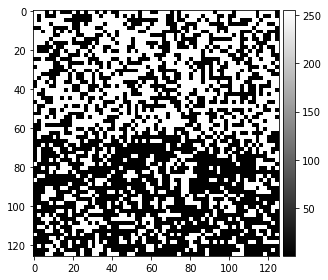

In [218]:
segm_result(h = 126, w = 126, dict_segm=segm_dict_sq(data = data_1, coefs = km_alg.cluster_centers_))

### При оценках параметров каждой области в лоб

Верхняя область: верно сегментированных пикселей - 4644, неверно - 3294
Нижняя область: верно сегментированных пикселей - 5322, неверно - 2616
Check image in half_im_segm.png


{'right_1st': 4644, 'right_2nd': 5322, 'wrong_1st': 3294, 'wrong_2nd': 2616}

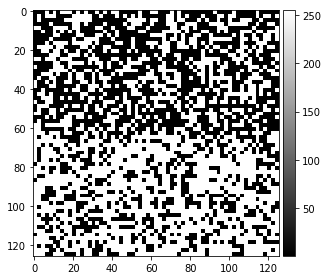

In [219]:
segm_result(h = 126, w = 126, dict_segm=segm_dict_sq(data = data_1, coefs = np.vstack((np.array(yule_walker_sol_arr(data_1[:64,:])).reshape(1,3), \
np.array(yule_walker_sol_arr(data_1[64:,:])).reshape(1,3)))))

### При истинных значениях коэффициентов

Верхняя область: верно сегментированных пикселей - 4424, неверно - 3514
Нижняя область: верно сегментированных пикселей - 5490, неверно - 2448
Check image in half_im_segm.png


{'right_1st': 4424, 'right_2nd': 5490, 'wrong_1st': 3514, 'wrong_2nd': 2448}

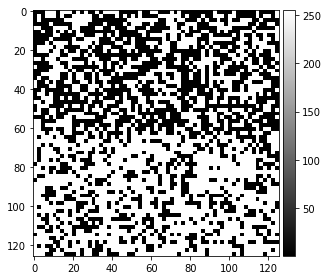

In [220]:
segm_result(h = 126, w = 126, dict_segm=segm_dict_sq(data = data_1, coefs = np.array([[0.1, 0.1, 0.1],
                                                                 [0.3, 0.1, 0.35]])))

## Сэмплы для сегментаций, с квадратом и треугольником внутри фоновой области

### С квадратом: область снаружи (фоновая) - [0.1, 0.1, 0.1]; область внутри квадрата - [0.15, 0.25, 0.35]

In [14]:
def autoreg_img_sq_of(h = 128, w = 128, depend_el = [(0, -1), (-1, 0), (-1, -1)], \
               coef_ = np.array([0.2, 0.2, 0.2]), coef_1 = np.array([0.1, 0.2, 0.6]), h_ = 64, w_ = 64):
    data = np.zeros((h, w), dtype=float)
    data_1 = np.zeros((h, w), dtype=int)
    data_wall_1 = np.zeros((h, w), dtype=int)
    #инициализируем генератор случайных чисел
    #np.random.seed(100)
    #noise_arr = np.random.random(h*w)
    #зададим шум на всей решетке
    cnt = 0
    for i in range(0, h):
        for j in range(0, w):
            data[i, j]+=(rand.normalvariate(0., 0.05))
            cnt+=1
    data_ = deepcopy(data)
    dat_ = data_[((h-h_)/2)-1:((h-h_)/2)+h_-1, ((w-w_)/2)-1:((w-w_)/2)+w_-1]
    #зададим уравнение линейной регрессии для всех элементов массива, без нулевой строки и нулевого столбца
    for i in range(1, h):
        for j in range(1, w):
            for k in range(len(depend_el)):
                data[i, j] += coef_[k]*data[i+depend_el[k][0], j+depend_el[k][1]]
    #нормируем фоновое изображение            
    data_wall = deepcopy(data)
    data_wall_aux = np.array([np.min(data_wall) for i in range(h*w)]).reshape(h, w)
    data_wall-=data_wall_aux
    norm_coef_w = 255./float(data_wall.max())
    data_wall*=norm_coef_w
    for i in range(data_wall.shape[0]):
        for j in range(data_wall.shape[1]):
            data_wall_1[i][j] = int(data_wall[i][j])
    
    dat_ = np.hstack((data[((h-h_)/2)-1:((h-h_)/2)+h_-1, ((w-w_)/2)-2].reshape(64, 1), dat_))
    dat_ = np.vstack((data[((h-h_)/2)-2, ((w-w_)/2)-2:((w-w_)/2)+w_-1].reshape(1, 65), dat_))
    
    for i in range(1, dat_.shape[0]):
        for j in range(1, dat_.shape[1]):
            for k in range(len(depend_el)):
                dat_[i, j] += coef_1[k]*dat_[i+depend_el[k][0], j+depend_el[k][1]]
    # dat_ - квадрат, заданный другой моделью. Надо засунуть его в исходную матрицу, отнормировать ее и вывести изображение.
    data[((h-h_)/2)-2:((h-h_)/2)+h_-1, ((w-w_)/2)-2:((w-w_)/2)+w_-1] = dat_
    
    #dat_ - квадрат, data - фон. Надо отнормировать каждый из этих кусков по отдельности, для оценки в лоб
    
    # нормировка
    dat_aux = np.array([np.min(data) for i in range(h*w)]).reshape(h, w)
    data-=dat_aux
            
    norm_coef = 255./float(data.max())
    data*=norm_coef
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data_1[i][j] = int(data[i][j])
    io.imsave('sq_segm_test.png', data_1, cmap = 'gray')
    return (data_1, data_1[((h-h_)/2)-2:((h-h_)/2)+h_, ((w-w_)/2)-2:((w-w_)/2)+w_], data_wall_1)

In [15]:
test_dat = autoreg_img_sq_of()

C:\Users\Cherry\Anaconda2\lib\site-packages\skimage\io\_io.py:132: UserWarning: sq_segm_test.png is a low contrast image
  warn('%s is a low contrast image' % fname)


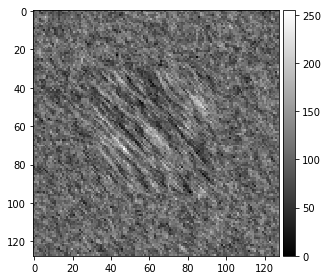

In [16]:
io.imshow(test_dat[0], cmap = 'gray')

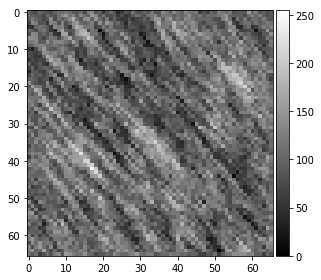

In [17]:
io.imshow(test_dat[1], cmap = 'gray')

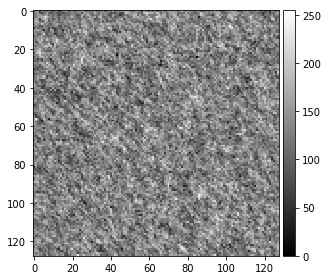

In [18]:
io.imshow(test_dat[2], cmap = 'gray')

### При истинных значениях коэффициентов

Фоновая область: верно сегментированных пикселей - 3457, неверно - 768
Внутренняя область: верно сегментированных пикселей - 5148, неверно - 6503
Check image in half_im_segm.png


C:\Users\Cherry\Anaconda2\lib\site-packages\skimage\io\_io.py:132: UserWarning: half_im_segm.png is a low contrast image
  warn('%s is a low contrast image' % fname)


{'right_1st': 3457, 'right_2nd': 5148, 'wrong_1st': 768, 'wrong_2nd': 6503}

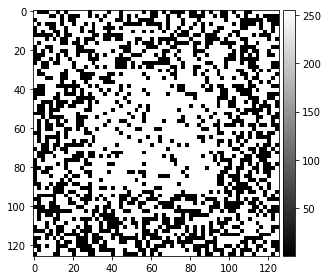

In [19]:
segm_result(h = 126, w = 126, h_ = 64, w_ = 64, type_ = 'square', \
            dict_segm=segm_dict_sq(data = autoreg_img_sq_of()[0], coefs = np.array([[0.1, 0.1, 0.1],
                                                                                                  [0.15, 0.25, 0.35]])))

### При коэффициентах, полученных с помощью оценок участков и дальнейшей кластеризации

In [56]:
%%time
data = autoreg_img_sq_of()[0]
a = []
cnt = 0
for i in range(0, int(data.shape[0]*0.75)+1, 8):
    for j in range(0, int(data.shape[1]*0.75)+1, 8):
        a.append(yule_walker_sol_arr(data[i:i+32, j:j+32]))
        cnt+=1
        #print cnt

Wall time: 8.37 s


In [57]:
km_alg_sq = cluster.KMeans(n_clusters=2).fit(a)
km_alg_sq.cluster_centers_

array([[0.10515833, 0.21596806, 0.31742778],
       [0.09278969, 0.10586082, 0.15501237]])

Фоновая область: верно сегментированных пикселей - 2744, неверно - 1481
Внутренняя область: верно сегментированных пикселей - 6339, неверно - 5312
Check image in half_im_segm.png


{'right_1st': 2744, 'right_2nd': 6339, 'wrong_1st': 1481, 'wrong_2nd': 5312}

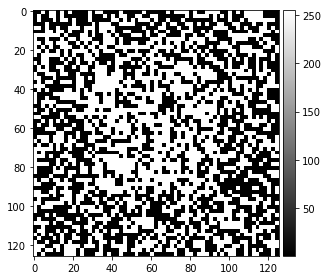

In [59]:
segm_result(h = 126, w = 126, h_ = 64, w_ = 64, type_ = 'square', \
            dict_segm=segm_dict_sq(data = data, coefs = np.array([km_alg_sq.cluster_centers_[1],
                                                                 km_alg_sq.cluster_centers_[0]])))

### При оценках параметров каждой области в лоб

Фоновая область: верно сегментированных пикселей - 2648, неверно - 1577
Внутренняя область: верно сегментированных пикселей - 6459, неверно - 5192
Check image in half_im_segm.png


{'right_1st': 2648, 'right_2nd': 6459, 'wrong_1st': 1577, 'wrong_2nd': 5192}

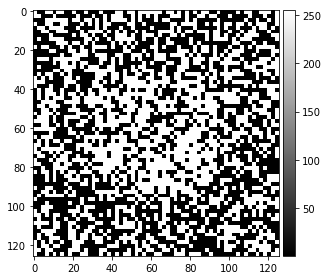

In [60]:
data = autoreg_img_sq_of()
a = yule_walker_sol_arr(data[2])
b = yule_walker_sol_arr(data[1])
segm_result(h = 126, w = 126, h_ = 64, w_ = 64, type_ = 'square', \
            dict_segm=segm_dict_sq(data = data[0], coefs = np.array([a,
                                                                     b])))

### С треугольником: область снаружи (фоновая) - [0.1, 0.1, 0.1]; область внутри квадрата - [0.15, 0.25, 0.35]

In [20]:
def autoreg_img_tr_of(h = 128, w = 128, depend_el = [(0, -1), (-1, 0), (-1, -1)], \
               coef_ = np.array([0.2, 0.2, 0.2]), coef_1 = np.array([0.1, 0.2, 0.6]), h_ = 64, w_ = 64):
    data = np.zeros((h, w), dtype=float)
    data_1 = np.zeros((h, w), dtype=int)
    data_wall_1 = np.zeros((h, w), dtype=int)
    data_targ_1 = np.zeros((h_+1,w_+1), dtype=int)
    #инициализируем генератор случайных чисел
    #np.random.seed(100)
    #noise_arr = np.random.random(h*w)
    #зададим шум на всей решетке
    cnt = 0
    for i in range(0, h):
        for j in range(0, w):
            data[i, j]+=(rand.normalvariate(0., 0.05))
            cnt+=1
    data_ = deepcopy(data)
    dat_ = data_[((h-h_)/2)-1:((h-h_)/2)+h_-1, ((w-w_)/2)-1:((w-w_)/2)+w_-1]
    #зададим уравнение линейной регрессии для всех элементов массива, без нулевой строки и нулевого столбца
    for i in range(1, h):
        for j in range(1, w):
            for k in range(len(depend_el)):
                data[i, j] += coef_[k]*data[i+depend_el[k][0], j+depend_el[k][1]]
    #нормируем фоновое изображение            
    data_wall = deepcopy(data)
    data_wall_aux = np.array([np.min(data_wall) for i in range(h*w)]).reshape(h, w)
    data_wall-=data_wall_aux
    norm_coef_w = 255./float(data_wall.max())
    data_wall*=norm_coef_w
    for i in range(data_wall.shape[0]):
        for j in range(data_wall.shape[1]):
            data_wall_1[i][j] = int(data_wall[i][j])
    
    dat_ = np.hstack((data[((h-h_)/2)-1:((h-h_)/2)+h_-1, ((w-w_)/2)-2].reshape(64, 1), dat_))
    dat_ = np.vstack((data[((h-h_)/2)-2, ((w-w_)/2)-2:((w-w_)/2)+w_-1].reshape(1, 65), dat_))
    
    for i in range(1, dat_.shape[0]):
        for j in range(1, dat_.shape[1]):
            for k in range(len(depend_el)):
                dat_[i, j] += coef_1[k]*dat_[i+depend_el[k][0], j+depend_el[k][1]]
                
    #dat_ - квадрат, из которого будем получать треугольник. Для оценки параметров в лоб, в ретюрне функции будем выводить его.
    #Отнормируем
    data_targ = deepcopy(dat_)
    data_targ_aux = np.array([np.min(data_targ) for i in range((h_+1)*(w_+1))]).reshape(h_+1, w_+1)
    data_targ-=data_targ_aux
    norm_coef_t = 255./float(data_targ.max())
    data_targ*=norm_coef_t
    for i in range(data_targ.shape[0]):
        for j in range(data_targ.shape[1]):
            data_targ_1[i][j] = int(data_targ[i][j])
    #dat_ - квадрат, заданный другой моделью. Надо его часть засунуть в фоновую матрицу.
    #data[((h-h_)/2)-2:((h-h_)/2)+h_-1, ((w-w_)/2)-2:((w-w_)/2)+w_-1] = dat_
    for i in range(h_+1):
        for j in range(i):
            data[((h-h_)/2)-2+i, ((w-w_)/2)-2+j] = dat_[i, j]
            
    
    #dat_ - квадрат, data - фон. Надо отнормировать каждый из этих кусков по отдельности, для оценки в лоб
    
    # нормировка
    dat_aux = np.array([np.min(data) for i in range(h*w)]).reshape(h, w)
    data-=dat_aux
            
    norm_coef = 255./float(data.max())
    data*=norm_coef
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data_1[i][j] = int(data[i][j])
    io.imsave('triangle_im_test.png', data_1, cmap = 'gray')
    return (data_1, data_targ_1, data_wall_1)

C:\Users\Cherry\Anaconda2\lib\site-packages\skimage\io\_io.py:132: UserWarning: triangle_im_test.png is a low contrast image
  warn('%s is a low contrast image' % fname)


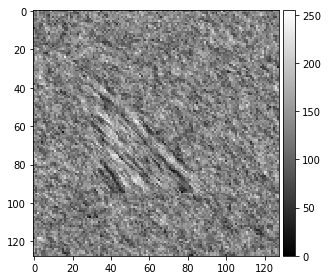

In [21]:
data_tr = autoreg_img_tr_of()
io.imshow(data_tr[0], cmap = 'gray')

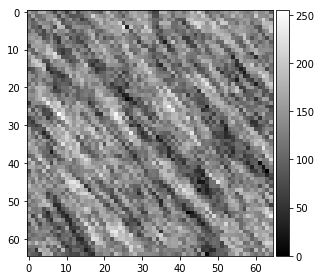

In [22]:
io.imshow(data_tr[1], cmap = 'gray')

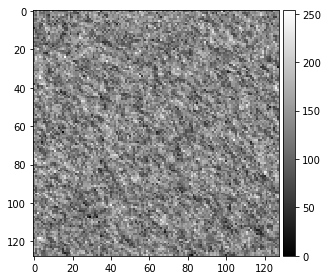

In [23]:
io.imshow(data_tr[2], cmap = 'gray')

### При истинных значениях коэффициентов

Фоновая область: верно сегментированных пикселей - 1810, неверно - 335
Внутренняя область: верно сегментированных пикселей - 6349, неверно - 7382
Check image in half_im_segm.png


{'right_1st': 1810, 'right_2nd': 6349, 'wrong_1st': 335, 'wrong_2nd': 7382}

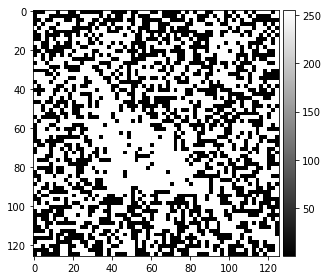

In [24]:
segm_result(h = 126, w = 126, h_ = 64, w_ = 64, type_ = 'triangle', \
            dict_segm=segm_dict_sq(data = data_tr[0], coefs = np.array([[0.1, 0.1, 0.1],
                                                                     [0.15, 0.25, 0.35]])))

### При коэффициентах, полученных с помощью оценок участков и дальнейшей кластеризации

In [84]:
%%time
#data_tr = autoreg_img_tr_of()
a = []
cnt = 0
for i in range(0, int(data_tr[0].shape[0]*0.75)+1, 8):
    for j in range(0, int(data_tr[1].shape[1]*0.75)+1, 8):
        a.append(yule_walker_sol_arr(data_tr[0][i:i+32, j:j+32]))
        cnt+=1
        #print cnt

Wall time: 8.76 s


In [85]:
km_alg_tr = cluster.KMeans(n_clusters=2).fit(a)
km_alg_tr.cluster_centers_

array([[0.11021148, 0.09644918, 0.14408033],
       [0.13386   , 0.18617667, 0.28653   ]])

Фоновая область: верно сегментированных пикселей - 1357, неверно - 788
Внутренняя область: верно сегментированных пикселей - 7504, неверно - 6227
Check image in half_im_segm.png


{'right_1st': 1357, 'right_2nd': 7504, 'wrong_1st': 788, 'wrong_2nd': 6227}

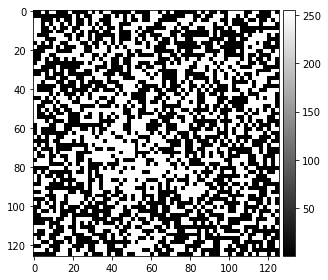

In [87]:
segm_result(h = 126, w = 126, h_ = 64, w_ = 64, type_ = 'triangle', \
            dict_segm=segm_dict_sq(data = data_tr[0], coefs = np.array([km_alg_tr.cluster_centers_[0],
                                                                 km_alg_tr.cluster_centers_[1]])))

### При оценках параметров каждой области в лоб

Фоновая область: верно сегментированных пикселей - 1335, неверно - 810
Внутренняя область: верно сегментированных пикселей - 7742, неверно - 5989
Check image in half_im_segm.png


{'right_1st': 1335, 'right_2nd': 7742, 'wrong_1st': 810, 'wrong_2nd': 5989}

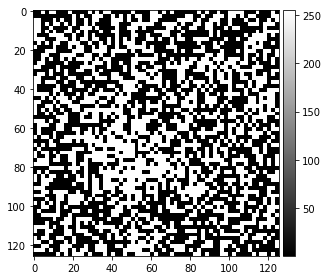

In [88]:
#data_tr = autoreg_img_tr_of()
a = yule_walker_sol_arr(data_tr[2])
b = yule_walker_sol_arr(data_tr[1])
segm_result(h = 126, w = 126, h_ = 64, w_ = 64, type_ = 'triangle', \
            dict_segm=segm_dict_sq(data = data_tr[0], coefs = np.array([a,
                                                                     b])))

### Результаты не совсем те, которые мы хотели бы видеть. Попробуем считать ошибки не  для квадратов 2 на 2 (4 пикселей) (т.е. рассматривать будем квадраты из 9 пикселей (3 на 3)), а для квадратов 4 на 4 (16 пикселей) (т.е. рассматривать будем квадраты из 25 пикселей (5 на 5)). Вообще, просто напишем функцию, которая возвращает словарь после сегментации, с новым параметром bound. Этот параметр определяет сторону квадрата пикселей, в котором мы считаем ошибку

In [227]:
t_a = np.array([i for i in range(12)]).reshape(3,4)
print t_a
for i in range(1, t_a.shape[0], 1):
        for j in range(1, t_a.shape[1], 1):
            print t_a[i-1:i+1, j-1:j+1]

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[0 1]
 [4 5]]
[[1 2]
 [5 6]]
[[2 3]
 [6 7]]
[[4 5]
 [8 9]]
[[ 5  6]
 [ 9 10]]
[[ 6  7]
 [10 11]]


In [230]:
def segm_dict_sq_bound(coefs, depend_el = [(0, -1), (-1, 0), (-1, -1)], data = data_1, bound = 4):
    # Вычтем из нашей матрицы среднее:
    data_1_ = deepcopy(data)
    m = np.mean(data)
    for i in range(data_1_.shape[0]):
        for j in range(data_1_.shape[1]):
            data_1_[i, j]-=m
    dict_segm = {}
    
    for i in range(bound, data.shape[0], 1):
        for j in range(bound, data.shape[1], 1):
            samp_1 = deepcopy(data_1_[i-bound:i+1, j-bound:j+1])
            samp_2 = deepcopy(data_1_[i-bound:i+1, j-bound:j+1])
            for i_ in range(1, samp_1.shape[0]):
                for j_ in range(1, samp_1.shape[1]):
                    for k in range(len(depend_el)):
                        samp_1[i_, j_] = coefs[0][k]*samp_1[i_+depend_el[k][0], j_+depend_el[k][1]]
                        samp_2[i_, j_] = coefs[1][k]*samp_2[i_+depend_el[k][0], j_+depend_el[k][1]]
            w_1 = err_sq(samp_1, data_1_[i-bound:i+1, j-bound:j+1])
            w_2 = err_sq(samp_2, data_1_[i-bound:i+1, j-bound:j+1])
            if w_1 < w_2:
                dict_segm.update({(i, j): 1})
                #for a in range(bound):
                    #for b in range(bound):
                       #dict_segm.update({(i-a, j-b): 1})
            else:
                dict_segm.update({(i, j): 255})
                #for a in range(bound):
                    #for b in range(bound):
                        #dict_segm.update({(i-a, j-b): 255})
    return dict_segm

Estimated params:[0, -1] - 0.030978; [-1, 0] - 0.501429; [-1, -1] - 0.130653;


(0.030977874304737057, 0.5014285659328819, 0.1306531651608099)

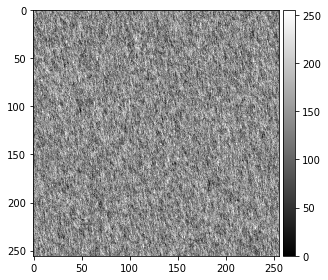

In [31]:
autoreg_img(depend_el = [(0, -1), (-1, 0), (-1, -1)], \
               coef_ = np.array([0.1, 0.5, 0.1]))
yule_walker_sol('autoreg_model.png')

In [196]:
c_1 = yule_walker_sol_arr(half_test[:64])
c_2 = yule_walker_sol_arr(half_test[64:])
print c_1, c_2

(0.1689, 0.1638, 0.2138) (0.0769, 0.07, 0.7148)


Верхняя область: верно сегментированных пикселей - 4026, неверно - 3848, доля - 0.511303
Нижняя область: верно сегментированных пикселей - 5501, неверно - 2754, доля - 0.666384


{'right_1st': 4026, 'right_2nd': 5501, 'wrong_1st': 3848, 'wrong_2nd': 2754}

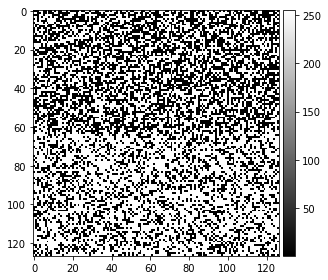

In [195]:
half_test = io.imread('half_im.png').astype(dtype = 'int32')
segm_result(name = 'C:\\Users\\Cherry\\segmentation_images\\second_half_single_segm.png',\
            h = 127, w = 127, h_ = 64, w_ = 64, type_ = 'half', \
            dict_segm=segm_dict_sq_bound(bound = 1, data = half_test,\
                                         coefs = np.array([c_1,c_2])), bound = 1)

Верхняя область: верно сегментированных пикселей - 4735, неверно - 2209, доля - 0.681884
Нижняя область: верно сегментированных пикселей - 6840, неверно - 1592, доля - 0.811195


{'right_1st': 4735, 'right_2nd': 6840, 'wrong_1st': 2209, 'wrong_2nd': 1592}

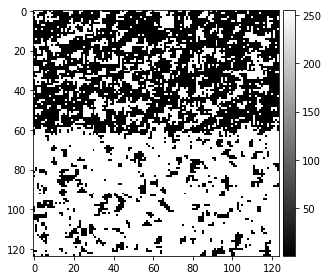

In [197]:
segm_result(name = 'C:\\Users\\Cherry\\segmentation_images\\second_half_quadr_segm.png',\
            h = 124, w = 124, h_ = 64, w_ = 64, type_ = 'half', \
            dict_segm=segm_dict_sq_bound(bound = 4, data = half_test,\
                                         coefs = np.array([c_1,c_2])), bound = 4)

### фон - [0.1, 0.5, 0.1], внутренняя - [0.05, 0.15, 0.7]

In [116]:
dat_dim = autoreg_img_sq_of(coef_ = np.array([0.1, 0.5, 0.1]),coef_1 = np.array([0.05, 0.15, 0.7]))
io.imsave('C:\\Users\\Cherry\\segmentation_images\\first_sq_orig.png', dat_dim[0], cmap = 'gray')

In [180]:
#test_read = io.imread('C:\\Users\\Cherry\\segmentation_images\\first_sq_orig.png')
#print type(dat_dim[0][0,0])
#print type(test_read[0, 0])
a = yule_walker_sol_arr(dat_dim[2])
print a
b = yule_walker_sol_arr(dat_dim[1])
print b

(0.0292, 0.4953, 0.135)
(0.0104, 0.156, 0.6841)


Фоновая область: верно сегментированных пикселей - 2882, неверно - 1343, доля - 0.682130
Внутренняя область: верно сегментированных пикселей - 6065, неверно - 5839, доля - 0.509493


{'right_1st': 2882, 'right_2nd': 6065, 'wrong_1st': 1343, 'wrong_2nd': 5839}

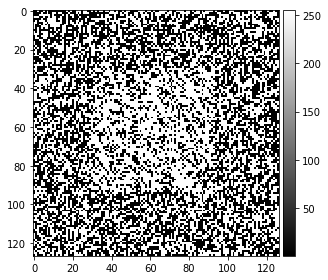

In [171]:
segm_result(h = 127, w = 127, h_ = 64, w_ = 64, type_ = 'square', \
            dict_segm=segm_dict_sq_bound(bound = 1, data = test_read.astype(dtype = 'int32'),\
                                         coefs = np.array([a,
                                                        b])), bound = 1)

Фоновая область: верно сегментированных пикселей - 3173, неверно - 1052, доля - 0.751006
Внутренняя область: верно сегментированных пикселей - 7023, неверно - 4128, доля - 0.629809


{'right_1st': 3173, 'right_2nd': 7023, 'wrong_1st': 1052, 'wrong_2nd': 4128}

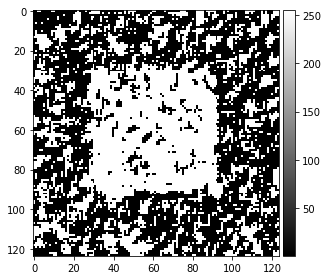

In [172]:
segm_result(name = 'C:\\Users\\Cherry\\segmentation_images\\first_sq_quadr_segm.png', h = 124, w = 124, h_ = 64, w_ = 64, type_ = 'square', \
            dict_segm=segm_dict_sq_bound(bound = 4, data = dat_dim[0].astype(dtype = 'int32'),\
                                         coefs = np.array([a,
                                                           b])), bound = 4)

Фоновая область: верно сегментированных пикселей - 3234, неверно - 991, доля - 0.765444
Внутренняя область: верно сегментированных пикселей - 6736, неверно - 4415, доля - 0.604071


{'right_1st': 3234, 'right_2nd': 6736, 'wrong_1st': 991, 'wrong_2nd': 4415}

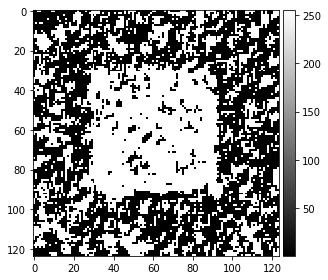

In [186]:
segm_result(name = 'C:\\Users\\Cherry\\segmentation_images\\first_sq_quadr_segm_clust.png', h = 124, w = 124, h_ = 64, w_ = 64, type_ = 'square', \
            dict_segm=segm_dict_sq_bound(bound = 4, data = dat_dim[0].astype(dtype = 'int32'),\
                                         coefs = np.array([km_alg.cluster_centers_[0],km_alg.cluster_centers_[1]])), bound = 4)

In [181]:
%%time
a = []
cnt = 0
for i in range(0, int(dat_dim[0].shape[0]*0.75)+1, 8):
    for j in range(0, int(dat_dim[0].shape[1]*0.75)+1, 8):
        a.append(yule_walker_sol_arr(dat_dim[0][i:i+32, j:j+32]))
        cnt+=1
        print cnt

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
Wall time: 8.39 s


In [183]:
km_alg = cluster.KMeans(n_clusters=2).fit(a)
km_alg.cluster_centers_

array([[ 0.01135   ,  0.43991531,  0.21788469],
       [-0.00909718,  0.22169577,  0.58875634]])

Text(0.5,0,u'[-1, -1]')

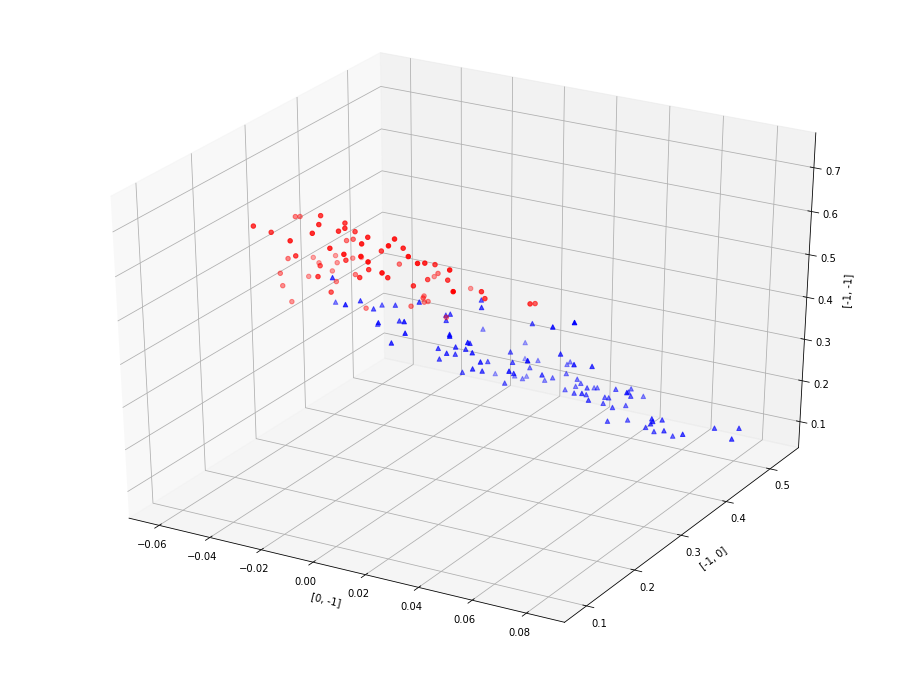

In [184]:
tr_ind = []
f_ind = []
for i in range(len(km_alg.labels_)):
    if km_alg.labels_[i] == 1:
        tr_ind.append(i)
    else:
        f_ind.append(i)

a = np.array(a)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

# 1st cluster
xs = a[[tr_ind]][:,0]
ys = a[[tr_ind]][:,1]
zs = a[[tr_ind]][:,2]
ax.scatter(xs, ys, zs, c='r', marker='o')

# 2nd cluster
xs = a[[f_ind]][:,0]
ys = a[[f_ind]][:,1]
zs = a[[f_ind]][:,2]
ax.scatter(xs, ys, zs, c='b', marker='^')

ax.set_xlabel('[0, -1]')
ax.set_ylabel('[-1, 0]')
ax.set_zlabel('[-1, -1]')

In [153]:
#data_tr = autoreg_img_tr_of()
a = yule_walker_sol_arr(data_train[2])
print a
b = yule_walker_sol_arr(data_train[1])
print b
segm_result(h = 124, w = 124, h_ = 64, w_ = 64, type_ = 'square', \
            dict_segm=segm_dict_sq_bound(bound = 4, data = data_train[0], coefs = np.array([a,
                                                                     b])))

NameError: name 'data_train' is not defined

In [151]:
data_tr = autoreg_img_tr_of(coef_ = np.array([0.1, 0.1, 0.7]), coef_1 = np.array([0.1, 0.5, 0.1]))

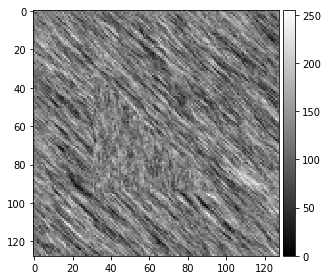

In [152]:
io.imshow(data_tr[0], cmap = 'gray')

In [177]:
#data_tr = autoreg_img_tr_of()
a = yule_walker_sol_arr(data_tr[2])
print a
b = yule_walker_sol_arr(data_tr[1])
print b

(0.0851, 0.0658, 0.7177)
(0.0427, 0.4937, 0.1325)


Фоновая область: верно сегментированных пикселей - 1213, неверно - 932, доля - 0.565501
Внутренняя область: верно сегментированных пикселей - 8789, неверно - 5195, доля - 0.628504
Wall time: 13.7 s


{'right_1st': 1213, 'right_2nd': 8789, 'wrong_1st': 932, 'wrong_2nd': 5195}

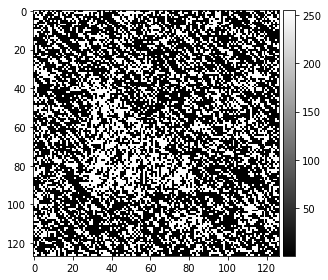

In [179]:
%%time
segm_result(name='C:\\Users\\Cherry\\segmentation_images\\third_tr_single_segm.png',\
            h = 127, w = 127, h_ = 64, w_ = 64, type_ = 'triangle', \
            dict_segm=segm_dict_sq_bound(bound = 1, data = io.imread('triangle_im_test.png').astype(dtype = 'int32'),\
                                         coefs = np.array([a, b])), bound = 1)

Фоновая область: верно сегментированных пикселей - 1216, неверно - 929, доля - 0.566900
Внутренняя область: верно сегментированных пикселей - 11441, неверно - 1790, доля - 0.864712


{'right_1st': 1216, 'right_2nd': 11441, 'wrong_1st': 929, 'wrong_2nd': 1790}

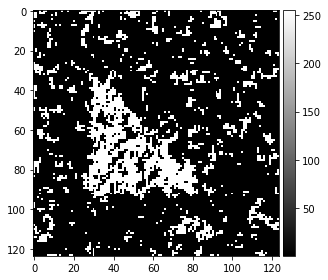

In [166]:
segm_result(name='C:\\Users\\Cherry\\segmentation_images\\third_tr_quadr_segm.png',\
            h = 124, w = 124, h_ = 64, w_ = 64, type_ = 'triangle', \
            dict_segm=segm_dict_sq_bound(bound = 4, data = io.imread('triangle_im_test.png').astype(dtype = 'int32'),\
                                         coefs = np.array([a,b])), bound = 4)

Фоновая область: верно сегментированных пикселей - 961, неверно - 1184, доля - 0.448019
Внутренняя область: верно сегментированных пикселей - 11141, неверно - 1114, доля - 0.909098


{'right_1st': 961, 'right_2nd': 11141, 'wrong_1st': 1184, 'wrong_2nd': 1114}

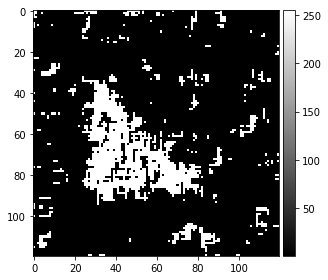

In [168]:
segm_result(name='C:\\Users\\Cherry\\segmentation_images\\third_tr_eight_segm.png',\
            h = 120, w = 120, h_ = 64, w_ = 64, type_ = 'triangle', \
            dict_segm=segm_dict_sq_bound(bound = 8, data = io.imread('triangle_im_test.png').astype(dtype = 'int32'),\
                                         coefs = np.array([a,b])), bound = 8)

In [208]:
a = io.imread('seno.png', as_grey = True)
io.imsave('seno_1.png', a, cmap = 'gray')

C:\Users\Cherry\Anaconda2\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
